# Exploratory Data Analysis

We will just look at the available dataset and taxonomy data, to get an overview understanding of it.

In [1]:
! pip install pandas numpy matplotlib seaborn plotly networkx nltk wordcloud scikit-learn sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
dataset = pd.read_csv('dataset.csv')
tax = pd.read_csv('tax.csv')

print(f"Dataset shape: {dataset.shape}")
print(f"Taxonomy shape: {tax.shape}")

Dataset shape: (202, 4)
Taxonomy shape: (45, 2)


Alright, so the dataset has only 202 rows, but 45 different categories. That makes it 4-5 entries per category, which seems like little data, but we can work with that.

## Quick Overview

In [4]:
print("\nDataset Info:")
print(dataset.info())

print("\nTaxonomy Info:")
print(tax.info())

print("\nDataset Sample:")
print(dataset.head(10))

print("\nTaxonomy Sample:")
print(tax.head(10))

# Check for duplicates
print(f"\nDuplicates in dataset: {dataset.duplicated().sum()}")
print(f"Duplicates in taxonomy: {tax.duplicated().sum()}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  202 non-null    int64 
 1   title       202 non-null    object
 2   section     202 non-null    object
 3   name        202 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB
None

Taxonomy Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   section  45 non-null     object
 1   name     45 non-null     object
dtypes: object(2)
memory usage: 852.0+ bytes
None

Dataset Sample:
   Unnamed: 0                                              title   section  \
0           0  Replacing two rubber mounts (rear) for rear ax...    Engine   
1           1  Disassembling and assembling cylinder head/mou...    Engine   
2           2  Remo

So we don't have duplicates and everything is a string, got it

In [5]:
# Sections and names counts from taxonomy
sections_count = tax['section'].value_counts()
print(f"\nNumber of unique sections in taxonomy: {len(sections_count)}")
print("Sections distribution:")
for section, count in sections_count.items():
    print(f" * {section}: {count} parts")

# Sections and names from the dataset
dataset_sections = dataset[dataset['section'] != 'unknown']['section'].value_counts()
dataset_names = dataset[dataset['name'] != 'unknown']['name'].value_counts()

print(f"\nNumber of unique sections in dataset: {len(dataset_sections)}")
print(f"Number of unique names in dataset: {len(dataset_names)}")

# Counts for the unknowns
unknown_sections = (dataset['section'] == 'unknown').sum()
unknown_names = (dataset['name'] == 'unknown').sum()
total_records = len(dataset)

print(f"\nUnknown sections: {unknown_sections} ({unknown_sections/total_records*100:.1f}%)")
print(f"Unknown names: {unknown_names} ({unknown_names/total_records*100:.1f}%)")


Number of unique sections in taxonomy: 3
Sections distribution:
 * Lighting: 21 parts
 * Engine: 16 parts
 * Brakes: 8 parts

Number of unique sections in dataset: 3
Number of unique names in dataset: 12

Unknown sections: 15 (7.4%)
Unknown names: 15 (7.4%)


## Data Visualisations

We will plot the counts for the items, to maybe spot some patterns

In [6]:
# We can have a larger plot with 4 subplots (the hierarchy, actual distribution for sections and names, then the percentage of unknown)
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Taxonomy Hierarchy', 'Dataset Sections Distribution',
                    'Dataset Names Distribution', 'Known vs Unknown Cases'),
    specs=[[{"type": "sunburst"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "pie"}]]
)

# I just like pastel colours so we can define a consistent one for each section
section_colors = px.colors.qualitative.Pastel[:len(tax['section'].unique())]
section_color_map = {section: color for section, color in zip(tax['section'].unique(), section_colors)}

# Sunburst chart for the taxonomy hierarchy
hierarchy_data = []
for section in tax['section'].unique():
    section_parts = tax[tax['section'] == section]['name'].tolist()
    for part in section_parts:
        hierarchy_data.append({
            'ids': f"{section}/{part}",
            'labels': part,
            'parents': section,
            'values': 1
        })
    hierarchy_data.append({
        'ids': section,
        'labels': section,
        'parents': "",
        'values': len(section_parts)
    })

sunburst_fig = go.Sunburst(
    ids=[d['ids'] for d in hierarchy_data],
    labels=[d['labels'] for d in hierarchy_data],
    parents=[d['parents'] for d in hierarchy_data],
    values=[d['values'] for d in hierarchy_data],
    branchvalues="total",
    marker=dict(colors=[section_color_map.get(label.split('/')[0], section_color_map.get(label))
                       for label in [d['labels'] for d in hierarchy_data]])
)

fig.add_trace(sunburst_fig, row=1, col=1)

# Dataset sections distribution
section_colors_mapped = [section_color_map.get(section) for section in dataset_sections.index]
fig.add_trace(
    go.Bar(x=dataset_sections.values, y=dataset_sections.index, orientation='h',
           marker_color=section_colors_mapped, showlegend=False),
    row=1, col=2
)

# Dataset names distribution
top_names = dataset_names
name_section_map = {}
for _, row in dataset[dataset['name'] != 'unknown'].iterrows():
    name_section_map[row['name']] = row['section']

name_colors_mapped = [section_color_map.get(name_section_map.get(name, 'unknown'))
                     for name in top_names.index]

fig.add_trace(
    go.Bar(x=top_names.values, y=top_names.index, orientation='h',
           marker_color=name_colors_mapped, showlegend=False),
    row=2, col=1
)

# Known vs Unknown pie chart
known_unknown = ['Known', 'Unknown']
known_unknown_values = [total_records - unknown_sections, unknown_sections]
fig.add_trace(
    go.Pie(labels=known_unknown, values=known_unknown_values, showlegend=False),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Dataset Overview Dashboard")
fig.show()

So we can see that, even if there are 45 names in the taxonomy, only 12 actually appear in the dataset.

Moreover, both the sections and names are highly imbalanced: "Drum Brake Backing Place" has only 1 entry, while "Interior / Exterior Bulb" have ~40 entries each. We should take that into consideration while training the models for it (to do a proper split and avoid introducing bias into the model).

As for the unknown cases, it is about 7.4%, so it shouldn't affect us too much during the training step. We will take a closer look at them during another section of the EDA.

## Word Analysis

We will look at the actual words from the dataset as bag-of-words and count their appearance, maybe we can also spot some patterns.

In [7]:
nltk.download('stopwords')
nltk.download('punkt_tab')
NLTK_STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
def tokenize_text(text):
    """Clean, lowercase, and tokenize text using NLTK."""
    if pd.isna(text):
        return []

    tokens = word_tokenize(str(text).lower())

    words = [
        word for word in tokens
        if word.isalpha() and len(word) > 2
    ]
    return words

# Extract all words from titles (with and without stopwords)
all_words_with_stopwords = []
all_words_no_stopwords = []
stopwords_found = []
num_titles = len(dataset)

for title in dataset['title']:
    words = tokenize_text(title)
    all_words_with_stopwords.extend(words)

    for word in words:
        if word in NLTK_STOPWORDS:
            stopwords_found.append(word)
        else:
            all_words_no_stopwords.append(word)

# Calculate word frequencies
word_freq_with = Counter(all_words_with_stopwords)
word_freq_without = Counter(all_words_no_stopwords)
stopword_freq = Counter(stopwords_found)

print(f"Total unique words (with stopwords): {len(word_freq_with)}")
print(f"Total unique words (without stopwords): {len(word_freq_without)}")
print(f"Total word occurrences (with stopwords): {len(all_words_with_stopwords)}")
print(f"Total word occurrences (without stopwords): {len(all_words_no_stopwords)}")

print("\nTop 15 most frequent words (with stopwords):")
for word, count in word_freq_with.most_common(15):
    print(f" - {word}: {count}")

print("\nTop 15 most frequent words (without stopwords):")
for word, count in word_freq_without.most_common(15):
    print(f" - {word}: {count}")

title_lengths = dataset['title'].str.len()
avg_char_length = title_lengths.mean()
avg_words_with_stopwords = len(all_words_with_stopwords) / num_titles if num_titles > 0 else 0
avg_words_without_stopwords = len(all_words_no_stopwords) / num_titles if num_titles > 0 else 0
word_counts = dataset['title'].apply(lambda x: len(tokenize_text(x)))

print("\nLength Statistics:")
print(f"Average title length: {avg_char_length:.1f} characters")
print(f"Average word count (with stopwords): {avg_words_with_stopwords:.1f}")
print(f"Average word count (without stopwords): {avg_words_without_stopwords:.1f}")

print(f"\nMaximum title length: {title_lengths.max()} characters")
print(f"Maximum word count per title: {word_counts.max()} words")

Total unique words (with stopwords): 231
Total unique words (without stopwords): 221
Total word occurrences (with stopwords): 1370
Total word occurrences (without stopwords): 1164

Top 15 most frequent words (with stopwords):
 - left: 95
 - and: 84
 - replacing: 74
 - right: 74
 - light: 61
 - removing: 59
 - the: 53
 - for: 50
 - rear: 43
 - front: 35
 - brake: 29
 - led: 24
 - bulb: 21
 - installing: 19
 - replace: 17

Top 15 most frequent words (without stopwords):
 - left: 95
 - replacing: 74
 - right: 74
 - light: 61
 - removing: 59
 - rear: 43
 - front: 35
 - brake: 29
 - led: 24
 - bulb: 21
 - installing: 19
 - replace: 17
 - panel: 17
 - cylinder: 16
 - engine: 16

Length Statistics:
Average title length: 53.2 characters
Average word count (with stopwords): 6.8
Average word count (without stopwords): 5.8

Maximum title length: 117 characters
Maximum word count per title: 15 words


So there are only about 231 unique words (221 if we exclude stopwords like "and", "the", "for", etc.), with the most common being words like: directions ("left", "right", "rear", "front"), simple actions ("replacing", "removing", "installing") or car parts ("brake", "led", "bulb", "panel"). This could be expected from such a dataset focusing on car mechanics.

Also, the average title has about ~53 characters and ~7 words in it, while the longest one has 117 characters and 15 words. So most of the available models, either being simple or transformer-based should work fine on it, without requiring data splitting.

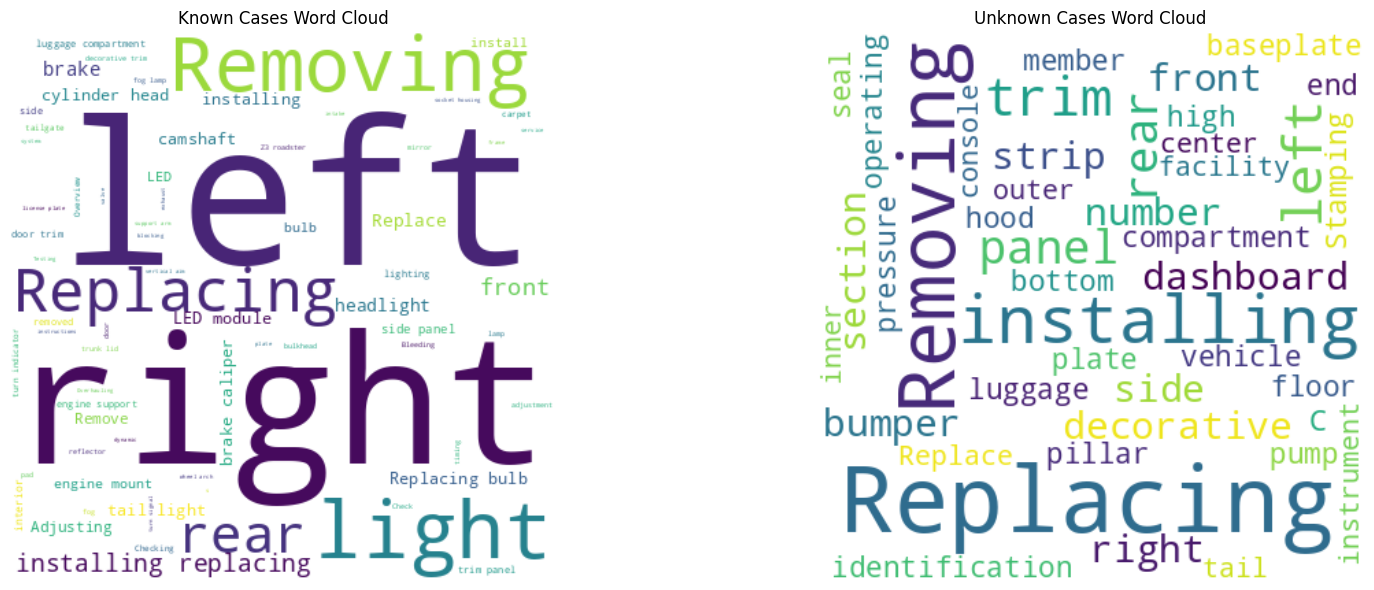

In [9]:
# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Known cases word cloud
known_titles = dataset[dataset['section'] != 'unknown']['title']
known_text = ' '.join(known_titles.astype(str))
if known_text.strip():
    wordcloud_known = WordCloud(width=400, height=400, background_color='white').generate(known_text)
    axes[0].imshow(wordcloud_known, interpolation='bilinear')
axes[0].set_title('Known Cases Word Cloud')
axes[0].axis('off')

# Unknown cases word cloud
unknown_titles = dataset[dataset['section'] == 'unknown']['title']
unknown_text = ' '.join(unknown_titles.astype(str))
if unknown_text.strip():
    wordcloud_unknown = WordCloud(width=400, height=400, background_color='white').generate(unknown_text)
    axes[1].imshow(wordcloud_unknown, interpolation='bilinear')
axes[1].set_title('Unknown Cases Word Cloud')
axes[1].axis('off')

plt.tight_layout()
plt.show()

It seems like the unknown cases have a pretty balanced distribution of words, with some unique ones (like "decorative" or "baseplate")

But also the known cases have some outliers (how does a car have a "refrigerator bulb"? is it an RV?).

## Unkonwn Cases Analysis

We only have 15 unknown / out-of-distribution (OOD) samples in our dataset, which is a too little value for training an anomaly detection model. We can use other approaches, such as distance-based methods (like [Out-of-Distribution Detection with Deep Nearest Neighbors](https://arxiv.org/pdf/2204.06507)), where we count the distance / similarity of the sample relative to existing training samples and set a threshold. If the distance is less than the threshold, we consider the sample as OOD and mark it as "unknown". As a drawback, this technique will disgard positive entries, so we should be careful in choosing a threshold value. In this subsection, we will try to find an adequate threshold (other works suggest one that marks as positive >= 95% of the original data).

In practice, we could train a better anomaly detection model, but that require more OOD samples. However, the distance based method should also work in practice with a larger set of valid and varied data, in combination with a vector database for a fast inference and look-up.

For computing the embeddings which are used for the distance, we will use a transformer-based model, which have an overall higher accuracy than traditional methods like bag-of-words or tf-idf approaches. As a compromise between speed and accuracy, we can use the `all-MiniLM-L6-v2` model (which [performs generally fine, while having a small size and fast inference](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models)). This model was trained on a large corpus of data, so it should be fine for our use case (while keeping in mind that it may have limitations for car-mechanics specific terminology).

In [10]:
# Load a lightweight sentence transformer model for generating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

all_titles = dataset['title'].tolist()
embeddings = model.encode(all_titles)

# Store the unknown and known cases
unknown_indices = dataset[dataset['section'] == 'unknown'].index.tolist()
known_indices = dataset[dataset['section'] != 'unknown'].index.tolist()

print("Embeddings were generated successfully")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings were generated successfully


In [11]:
# First, analyze known-to-known similarities for threshold selection
print(f"Known-to-known similarity analysis ({len(known_indices)} known cases):")

known_embeddings = embeddings[known_indices]
known_similarities = cosine_similarity(known_embeddings)

# Calculate maximum similarity for each known case (excluding self)
known_max_similarities = []
for index in range(len(known_indices)):
    # Get similarities for the current row, excluding diagonal (self-similarity)
    row_sims = np.concatenate([known_similarities[index, :index], known_similarities[index, index+1:]])
    if len(row_sims) > 0:
        known_max_similarities.append(np.max(row_sims))

# Get upper triangle to avoid self-similarity for overall stats
mask = np.triu(np.ones_like(known_similarities), k=1).astype(bool)
known_to_known_sims = known_similarities[mask]

print(f"Number of known-to-known pairs: {len(known_to_known_sims)}")
print(f"Mean similarity (all pairs): {np.mean(known_to_known_sims):.3f}")
print(f"Std similarity (all pairs): {np.std(known_to_known_sims):.3f}")
print(f"Min similarity (all pairs): {np.min(known_to_known_sims):.3f}")
print(f"Max similarity (all pairs): {np.max(known_to_known_sims):.3f}")
print(f"Median similarity (all pairs): {np.median(known_to_known_sims):.3f}")

# Add maximum similarity statistics
print(f"\nMaximum similarity per known case (excluding self):")
print(f"Mean max similarity: {np.mean(known_max_similarities):.3f}")
print(f"Median max similarity: {np.median(known_max_similarities):.3f}")
print(f"Std max similarity: {np.std(known_max_similarities):.3f}")
print(f"Min max similarity: {np.min(known_max_similarities):.3f}")
print(f"Max max similarity: {np.max(known_max_similarities):.3f}")

# Suggest thresholds based on max similarities
percentiles = [5, 10, 20, 50, 75, 85, 90, 95]
print(f"\nMax similarity percentiles:")
for p in percentiles:
    threshold = np.percentile(known_max_similarities, p)
    print(f" - {p:>2}th percentile: {threshold:.3f}")

Known-to-known similarity analysis (187 known cases):
Number of known-to-known pairs: 17391
Mean similarity (all pairs): 0.302
Std similarity (all pairs): 0.189
Min similarity (all pairs): -0.162
Max similarity (all pairs): 1.000
Median similarity (all pairs): 0.292

Maximum similarity per known case (excluding self):
Mean max similarity: 0.861
Median max similarity: 0.897
Std max similarity: 0.126
Min max similarity: 0.386
Max max similarity: 1.000

Max similarity percentiles:
 -  5th percentile: 0.606
 - 10th percentile: 0.681
 - 20th percentile: 0.762
 - 50th percentile: 0.897
 - 75th percentile: 0.956
 - 85th percentile: 0.979
 - 90th percentile: 0.990
 - 95th percentile: 0.996


So the maximum similarity of known titles to known titles seems high, with a median of 0.897. That means that we could set a threshold somewhere to directly omit titles with a low similarity score (however, this would also omit true positive cases). There are also cases when the similarity is >= 0.99, but after manual inspection, it seems like they are pairs which look similar or mean similar things.

In [12]:
# Now analyze unknown cases
print(f"Unknown-to-known similarity analysis ({len(unknown_indices)} unknown cases):")

unknown_max_similarities = []

for unknown_idx in unknown_indices:
    unknown_emb = embeddings[unknown_idx].reshape(1, -1)
    known_embs = embeddings[known_indices]

    sims = cosine_similarity(unknown_emb, known_embs)[0]
    max_sim_idx = np.argmax(sims)
    max_similarity = sims[max_sim_idx]
    most_similar_idx = known_indices[max_sim_idx]

    unknown_max_similarities.append(max_similarity)

    # Display most similar match
    print(f"\nUnknown: '{dataset.loc[unknown_idx, 'title']}'")
    print(f"Most similar: '{dataset.loc[most_similar_idx, 'title']}'")
    print(f" Section: {dataset.loc[most_similar_idx, 'section']}")
    print(f" Name: {dataset.loc[most_similar_idx, 'name']}")
    print(f" Similarity: {max_similarity:.3f}")

# Statistics for unknown cases
print(f"\nUnknown case maximum similarity statistics:")
print(f" Mean max similarity: {np.mean(unknown_max_similarities):.3f}")
print(f" Median max similarity: {np.median(unknown_max_similarities):.3f}")
print(f" Std max similarity: {np.std(unknown_max_similarities):.3f}")
print(f" Min max similarity: {np.min(unknown_max_similarities):.3f}")
print(f" Max max similarity: {np.max(unknown_max_similarities):.3f}")

percentiles = [5, 10, 20, 50, 75, 80, 85, 90, 95]
print(f"\nMax similarity percentiles:")
for p in percentiles:
    threshold = np.percentile(unknown_max_similarities, p)
    print(f" - {p:>2}th percentile: {threshold:.3f}")

Unknown-to-known similarity analysis (15 unknown cases):

Unknown: 'Replacing luggage compartment floor and side member on the left'
Most similar: 'Removing and installing/replacing luggage compartment light'
 Section: Lighting
 Name: Interior Bulb
 Similarity: 0.535

Unknown: 'Removing and installing high pressure pump'
Most similar: 'Removing and installing/replacing inlet camshaft '
 Section: Engine
 Name: Camshaft
 Similarity: 0.420

Unknown: 'Removing and installing/replacing the number plate baseplate'
Most similar: 'Removing and installing/replacing left or right number/license plate light'
 Section: Lighting
 Name: Exterior Bulb
 Similarity: 0.665

Unknown: 'Removing and installing front end'
Most similar: 'Removing and installing/replacing complete front left turn signal lamp'
 Section: Lighting
 Name: Side Marker/Fog Lamp Assembly
 Similarity: 0.501

Unknown: 'Removing and installing/replacing trim on C-pillar at bottom left or right'
Most similar: 'Removing and installing/re

Interestingly, the most similar known cases to the unknown one look similar, but their score is maximum 0.756, with a median of 0.533, which is below the median of the known-to-known pairs. So the samples do seem to have different distributions.

In [13]:
from scipy import stats

# Quick check to see if they have different distributions
mann_whitney_test = stats.mannwhitneyu(unknown_max_similarities, known_max_similarities, alternative='two-sided')

print(f"Test Statistic: {mann_whitney_test.statistic}")
print(f"P-value: {mann_whitney_test.pvalue}")

Test Statistic: 137.0
P-value: 6.3485000041612e-09


Yup, the max similarities also have different distributions, according to the Mann-Whitney U test.

In [14]:
# Known-to-known maximum similarities
fig1 = px.histogram(
    x=known_max_similarities,
    nbins=20,
    title="Distribution of Maximum Similarities (Known-to-Known)",
    labels={'x': 'Maximum Similarity Score', 'y': 'Frequency'},
    color_discrete_sequence=['#687FE5']
)
fig1.add_vline(x=np.mean(known_max_similarities), line_dash="dash",
                line_color="red", annotation_text=f"Mean: {np.mean(known_max_similarities):.3f}")
fig1.add_vline(x=np.median(known_max_similarities), line_dash="dash",
                line_color="orange", annotation_text=f"Median: {np.median(known_max_similarities):.3f}")
fig1.show()

# Unknown-to-known maximum similarities
fig2 = px.histogram(
    x=unknown_max_similarities,
    nbins=min(20, len(unknown_max_similarities)),
    title="Distribution of Maximum Similarities (Unknown-to-Known)",
    labels={'x': 'Maximum Similarity Score', 'y': 'Frequency'},
    color_discrete_sequence=['#FCD8CD']
)
fig2.add_vline(x=np.mean(unknown_max_similarities), line_dash="dash",
                line_color="red", annotation_text=f"Mean: {np.mean(unknown_max_similarities):.3f}")
fig2.add_vline(x=np.median(unknown_max_similarities), line_dash="dash",
                line_color="orange", annotation_text=f"Median: {np.median(unknown_max_similarities):.3f}")

fig2.show()

# Combined comparison plot
fig3 = go.Figure()

fig3.add_trace(go.Histogram(
    x=known_max_similarities,
    name='Known-to-Known Max',
    opacity=0.7,
    nbinsx=20,
    marker_color='#687FE5'
))

fig3.add_trace(go.Histogram(
    x=unknown_max_similarities,
    name='Unknown-to-Known Max',
    opacity=0.7,
    nbinsx=20,
    marker_color='#FCD8CD'
))

fig3.update_layout(
    title="Comparison of Maximum Similarity Distributions",
    xaxis_title="Maximum Similarity Score",
    yaxis_title="Frequency",
    barmode='overlay'
)

fig3.show()

Through this analysis, we can see that the known and unknown samples have different distributions and that we may choose **0.55** as an initial threshold for the unknown / known samples. This values retains ~95% of the original known data, while skipping ~75% of the true unknown cases. Of course, we may also modify this value or try other approaches, but it seems fine as an initial step.

## Summary

So, during this exploratory data analysis of the given data, we saw that we have 202 entry points in the dataset file and 45 possible names, split into 3 sections for the classification. Out of the 202 points, 15 are marked as unknown and only 12 unique names appear in the data, with an imbalanced distribution.

The available titles contain 231 unique words, with the average title having ~54 characters and ~7 words, while the maximum is 117 characters and 15 words. These suggest that we can employ simple or transformer based models without splitting the input data for now, as these have an input window limit of ~256-512 tokens.

As for the unknown titles, we analysed the similarity of their embeddings in comparison with the known entries. The results shows that their similarity distribution differs from that of the known entries, so we may employ techniques that separate them based on a distance threshold of 0.55.

# Training Models

There are different model approaches we can employ for this problem. During this section, we will try different ones, measuring their accuracy and inference speed, in order to help use make a decision on what model to choose for serving. The approaches chosen are:
* TF-IDF + Logistic Regression
* TF-IDF + Support Vector Machines
* TF-IDF + Random Forest
* TF-IDF + XGBoost
* Embedding Model + Logistic Regression

We should also train on the taxonomy entries, rather than on the present entries from the dataset, to add the possibility of the model to be later updated and provide an easier transition.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                           confusion_matrix, classification_report)
import xgboost as xgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F

In [16]:
# Load datasets
dataset = pd.read_csv('dataset.csv')
tax = pd.read_csv('tax.csv')

# Remove unknown entries for training
clean_dataset = dataset[dataset['name'] != 'unknown'].copy().reset_index(drop=True)

# Create complete label space from taxonomy
all_names = sorted(tax['name'].unique())
all_sections = sorted(tax['section'].unique())

In [30]:
# Prepare the train / test data
# Create stratified train-test split with special handling for rare classes
def create_stratified_split(df, test_size=0.2, min_test_samples=1):
    name_counts = df['name'].value_counts()
    print(f"\nClass distribution:")
    for name, count in name_counts.items():
        print(f"{name}: {count}")

    train_indices = []
    test_indices = []

    for name in name_counts.index:
        class_indices = df[df['name'] == name].index.tolist()
        class_size = len(class_indices)

        if class_size == 1:
            test_size_class = 0
        elif class_size <= 3:
            # For very small classes, put 1 in test, rest in train
            test_size_class = min(1, class_size)
        else:
            # For larger classes, use proportional split but ensure at least min_test_samples
            test_size_class = max(min_test_samples, int(class_size * test_size))

        # np.random.seed(42)
        test_idx = np.random.choice(class_indices, size=test_size_class, replace=False)
        train_idx = [idx for idx in class_indices if idx not in test_idx]

        train_indices.extend(train_idx)
        test_indices.extend(test_idx)

        print(f"{name}: {len(train_idx)} train, {len(test_idx)} test")

    return train_indices, test_indices

# We demand rigidly defined areas of doubt and uncertainty    seed value
np.random.seed(42)

train_indices, test_indices = create_stratified_split(clean_dataset)

X_train = clean_dataset.iloc[train_indices]['title'].values
y_train = clean_dataset.iloc[train_indices]['name'].values
X_test = clean_dataset.iloc[test_indices]['title'].values
y_test = clean_dataset.iloc[test_indices]['name'].values

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Create label encoders
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(all_names)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Number of classes: {len(label_encoder.classes_)}")


Class distribution:
Exterior Bulb: 48
Interior Bulb: 37
Engine Mount: 17
Brakes: 17
Disc Brake Caliper: 15
Camshaft: 14
Cylinder Head: 12
Headlamp Alignment: 11
Side Marker/Fog Lamp Assembly: 10
Foglamp Alignment: 3
Fog Lamp Bulb: 2
Drum Brake Backing Plate: 1
Exterior Bulb: 39 train, 9 test
Interior Bulb: 30 train, 7 test
Engine Mount: 14 train, 3 test
Brakes: 14 train, 3 test
Disc Brake Caliper: 12 train, 3 test
Camshaft: 12 train, 2 test
Cylinder Head: 10 train, 2 test
Headlamp Alignment: 9 train, 2 test
Side Marker/Fog Lamp Assembly: 8 train, 2 test
Foglamp Alignment: 2 train, 1 test
Fog Lamp Bulb: 1 train, 1 test
Drum Brake Backing Plate: 1 train, 0 test

Train set: 152 samples
Test set: 35 samples
Number of classes: 45


In [18]:
# We can't directly use XGBClassifier in our case, so we need to create a small adapter for it,
# which maps labels to consecutive integers
class XGBClassifierFixed(xgb.XGBClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._label_map = None
        self._reverse_label_map = None

    def fit(self, X, y):
        # Create mapping for non-consecutive labels
        unique_labels = np.unique(y)
        self._label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
        self._reverse_label_map = {new_label: old_label for old_label, new_label in self._label_map.items()}

        # Transform labels to consecutive integers
        y_mapped = np.array([self._label_map[label] for label in y])
        return super().fit(X, y_mapped)

    def predict(self, X):
        y_pred_mapped = super().predict(X)
        # Transform back to original labels
        return np.array([self._reverse_label_map[label] for label in y_pred_mapped])

    def predict_proba(self, X):
        return super().predict_proba(X)

In [23]:
print("Creating TF-IDF features")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=1,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

# Define models (we also did hyperparameter tuning offscreen using grid search,
# but the results were not significantly better with other parameters)
traditional_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True, kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifierFixed(random_state=42, eval_metric='mlogloss')
}

# Store results
results = {}

Creating TF-IDF features
TF-IDF feature shape: (152, 1047)


In [31]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, inference_test_data):
    """Evaluate a model and return comprehensive metrics"""

    print(f"\nTraining {model_name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # For measuring the inference time, we will run the model 100 times through all the data
    # We will also include the tfidf transform in this time, to "simulate" real-life scenarios
    print(f"Measuring inference time for {model_name}...")
    inference_times = []
    for i in range(100):
        start_time = time.time()
        predictions_sequential = []
        for sample_text in inference_test_data:
            # Transform text to TF-IDF
            sample_tfidf = tfidf_vectorizer.transform([sample_text])
            # Predict
            pred = model.predict(sample_tfidf)[0]
            predictions_sequential.append(pred)
        inference_time_run = time.time() - start_time
        inference_times.append(inference_time_run)

    avg_inference_time = np.mean(inference_times)
    std_inference_time = np.std(inference_times)
    per_sample_time = avg_inference_time / X_test.shape[0]

    print(f" Avg inference time (100 runs): {avg_inference_time:.4f}s ± {std_inference_time:.4f}s")
    print(f" Per sample time: {per_sample_time:.6f}s")
    print(f" Samples per second: {1/per_sample_time:.1f}")

    # Prediction
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=range(len(label_encoder.classes_)), zero_division=0)

    # Weighted and micro averages
    precision_micro = precision_recall_fscore_support(y_test, y_pred, average='micro', zero_division=0)[0]
    recall_micro = precision_recall_fscore_support(y_test, y_pred, average='micro', zero_division=0)[1]
    f1_micro = precision_recall_fscore_support(y_test, y_pred, average='micro', zero_division=0)[2]

    precision_weighted = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)[0]
    recall_weighted = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)[1]
    f1_weighted = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)[2]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))

    metrics = {
        'accuracy': accuracy,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'confusion_matrix': cm,
        'train_time': train_time,
        'inference_time': avg_inference_time,
        'inference_time_std': std_inference_time,
        'per_sample_time': per_sample_time,
        'samples_per_second': 1/per_sample_time,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"\n{model_name} completed!")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" F1 (weighted): {f1_weighted:.4f}")
    print(f" Training time: {train_time:.2f}s")
    print(f" Inference time: {avg_inference_time:.4f}s")
    print(f"\n")

    return metrics

# Train traditional models
for name, model in traditional_models.items():
    results[name] = evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train_encoded, y_test_encoded, name, X_test)


Training Logistic Regression...
Measuring inference time for Logistic Regression...
 Avg inference time (10 runs): 0.0269s ± 0.0087s
 Per sample time: 0.000769s
 Samples per second: 1299.7

Logistic Regression completed!
 Accuracy: 0.7429
 F1 (weighted): 0.7268
 Training time: 0.35s
 Inference time: 0.0269s



Training SVM...
Measuring inference time for SVM...
 Avg inference time (10 runs): 0.0334s ± 0.0072s
 Per sample time: 0.000954s
 Samples per second: 1048.3

SVM completed!
 Accuracy: 0.7143
 F1 (weighted): 0.7013
 Training time: 0.05s
 Inference time: 0.0334s



Training Random Forest...
Measuring inference time for Random Forest...
 Avg inference time (10 runs): 0.3528s ± 0.0731s
 Per sample time: 0.010080s
 Samples per second: 99.2

Random Forest completed!
 Accuracy: 0.6000
 F1 (weighted): 0.5516
 Training time: 0.37s
 Inference time: 0.3528s



Training XGBoost...
Measuring inference time for XGBoost...
 Avg inference time (10 runs): 0.0596s ± 0.0147s
 Per sample time: 0.00

In [40]:
# Custom Dataset class
class RepairDataset(Dataset):
    def __init__(self, texts, labels, embeddings=None):
        self.texts = texts
        self.labels = labels
        self.embeddings = embeddings

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if self.embeddings is not None:
            return {
                'embedding': torch.FloatTensor(self.embeddings[idx]),
                'label': torch.LongTensor([self.labels[idx]])
            }
        else:
            return {
                'text': self.texts[idx],
                'label': torch.LongTensor([self.labels[idx]])
            }

# Simple neural network for embeddings
class EmbeddingClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes, hidden_dim=128, dropout=0.3):
        super(EmbeddingClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

print("Generating embeddings to speed up the training")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embeddings = sentence_model.encode(X_train)
X_test_embeddings = sentence_model.encode(X_test)

print(f"Embedding shape: {X_train_embeddings.shape}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets and dataloaders
train_dataset = RepairDataset(X_train, y_train_encoded, X_train_embeddings)
test_dataset = RepairDataset(X_test, y_test_encoded, X_test_embeddings)

# 16 should be a suitable batch size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

embedding_dim = X_train_embeddings.shape[1]
num_classes = len(label_encoder.classes_)
model = EmbeddingClassifier(embedding_dim, num_classes).to(device)

# Training setup, cross entropy loss and adam are good initial choices
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training function
def train_deep_model(model, train_loader, test_loader, epochs=50):
    print(f"\nTraining the deep learning model for {epochs} epochs...")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, batch in enumerate(train_loader):
            embeddings = batch['embedding'].squeeze().to(device)
            labels = batch['label'].squeeze().to(device)

            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in test_loader:
                embeddings = batch['embedding'].squeeze().to(device)
                labels = batch['label'].squeeze().to(device)

                outputs = model(embeddings)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(test_loader)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    train_time = time.time() - start_time

    # Final evaluation
    model.eval()
    all_predictions = []
    all_probabilities = []

    # Get final predictions for evaluation (batch mode)
    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embedding'].squeeze().to(device)
            outputs = model(embeddings)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Inference timing
    print(f"Measuring inference time for deep learning model (including embedding generation)...")

    inference_times = []
    for i in range(10):
        start_time = time.time()
        predictions_sequential = []
        model.eval()
        with torch.no_grad():
            for sample_text in X_test:
                sample_embedding = sentence_model.encode([sample_text])
                sample_tensor = torch.FloatTensor(sample_embedding).to(device)
                output = model(sample_tensor)
                _, pred = output.max(1)
                predictions_sequential.append(pred.cpu().numpy()[0])

        inference_time_run = time.time() - start_time
        inference_times.append(inference_time_run)

    avg_inference_time = np.mean(inference_times)
    std_inference_time = np.std(inference_times)
    per_sample_time = avg_inference_time / len(X_test)

    print(f" Avg inference time (10 runs, with embeddings): {avg_inference_time:.4f}s ± {std_inference_time:.4f}s")
    print(f" Per sample time (with embeddings): {per_sample_time:.6f}s")
    print(f" Samples per second (with embeddings): {1/per_sample_time:.1f}")

    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, all_predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_encoded, all_predictions, average=None,
        labels=range(len(label_encoder.classes_)), zero_division=0
    )

    precision_micro = precision_recall_fscore_support(y_test_encoded, all_predictions, average='micro', zero_division=0)[0]
    recall_micro = precision_recall_fscore_support(y_test_encoded, all_predictions, average='micro', zero_division=0)[1]
    f1_micro = precision_recall_fscore_support(y_test_encoded, all_predictions, average='micro', zero_division=0)[2]

    precision_weighted = precision_recall_fscore_support(y_test_encoded, all_predictions, average='weighted', zero_division=0)[0]
    recall_weighted = precision_recall_fscore_support(y_test_encoded, all_predictions, average='weighted', zero_division=0)[1]
    f1_weighted = precision_recall_fscore_support(y_test_encoded, all_predictions, average='weighted', zero_division=0)[2]

    cm = confusion_matrix(y_test_encoded, all_predictions, labels=range(len(label_encoder.classes_)))

    return {
        'accuracy': accuracy,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'confusion_matrix': cm,
        'train_time': train_time,
        'inference_time': avg_inference_time,
        'inference_time_std': std_inference_time,
        'per_sample_time': per_sample_time,
        'samples_per_second': 1/per_sample_time,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

# Train deep learning model
# (after some off-screen testing, 40 epochs is a good cut-off, as the validation loss increases after that point, signaling overfitting)
results['Deep Learning (Embeddings + NN)'] = train_deep_model(model, train_loader, test_loader, epochs=40)

Generating embeddings to speed up the training
Embedding shape: (152, 384)
Using device: cpu

Training the deep learning model for 40 epochs...
Epoch 0/40: Train Loss: 3.7931, Train Acc: 0.0987, Val Loss: 3.7488, Val Acc: 0.3143
Epoch 10/40: Train Loss: 1.2233, Train Acc: 0.5658, Val Loss: 2.0116, Val Acc: 0.5714
Epoch 20/40: Train Loss: 0.6448, Train Acc: 0.8026, Val Loss: 1.3819, Val Acc: 0.8000
Epoch 30/40: Train Loss: 0.3613, Train Acc: 0.8684, Val Loss: 1.0007, Val Acc: 0.8000
Measuring inference time for deep learning model (including embedding generation)...
 Avg inference time (10 runs, with embeddings): 0.8615s ± 0.1410s
 Per sample time (with embeddings): 0.024613s
 Samples per second (with embeddings): 40.6


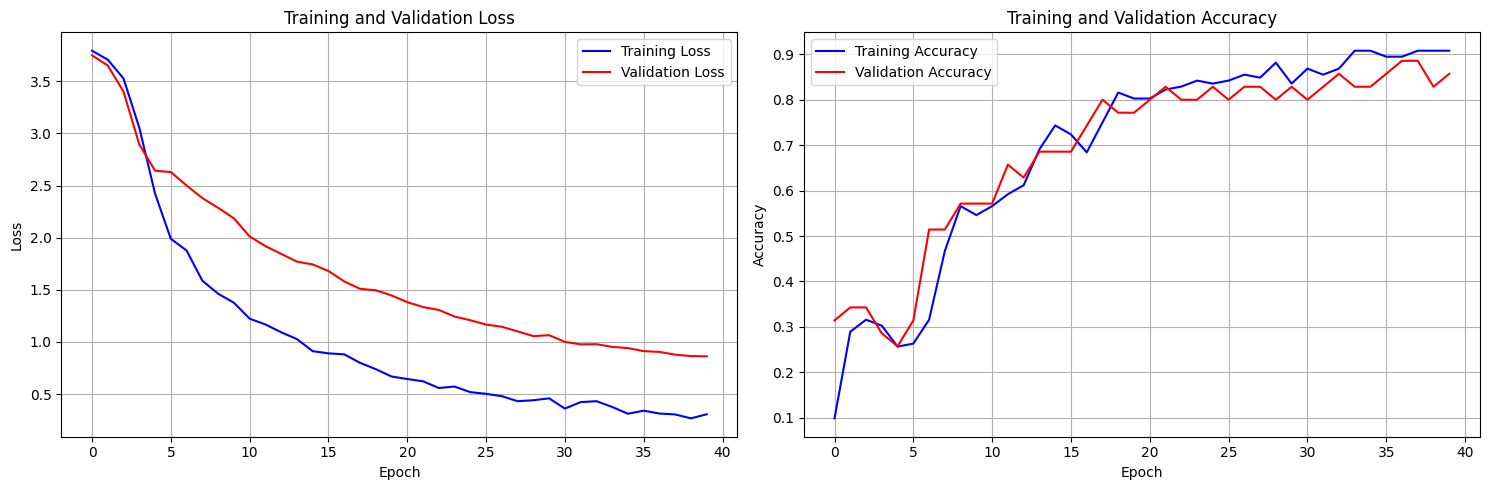

In [42]:
# Plot training curves for the model
dl_results = results['Deep Learning (Embeddings + NN)']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(len(dl_results['train_losses']))

# Loss curves
ax1.plot(epochs, dl_results['train_losses'], label='Training Loss', color='blue')
ax1.plot(epochs, dl_results['val_losses'], label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(epochs, dl_results['train_accuracies'], label='Training Accuracy', color='blue')
ax2.plot(epochs, dl_results['val_accuracies'], label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Now, let's plot the metrics and inference results, in order to choose a model

Model Comparison:
                          Model  Accuracy  Precision (Weighted)  Recall (Weighted)  F1 (Weighted)  F1 (Micro)  Training Time (s)  Avg Inference Time (s)  Per Sample Time (s)  Samples/sec
Deep Learning (Embeddings + NN)    0.8571                0.8486             0.8571         0.8488      0.8571             1.3055                  0.8615               0.0246      40.6286
            Logistic Regression    0.7429                0.7371             0.7429         0.7268      0.7429             0.3543                  0.0269               0.0008    1299.7315
                            SVM    0.7143                0.7195             0.7143         0.7013      0.7143             0.0530                  0.0334               0.0010    1048.3463
                        XGBoost    0.6286                0.6246             0.6286         0.5896      0.6286             0.3990                  0.0596               0.0017     587.0210
                  Random Forest    0.6000      

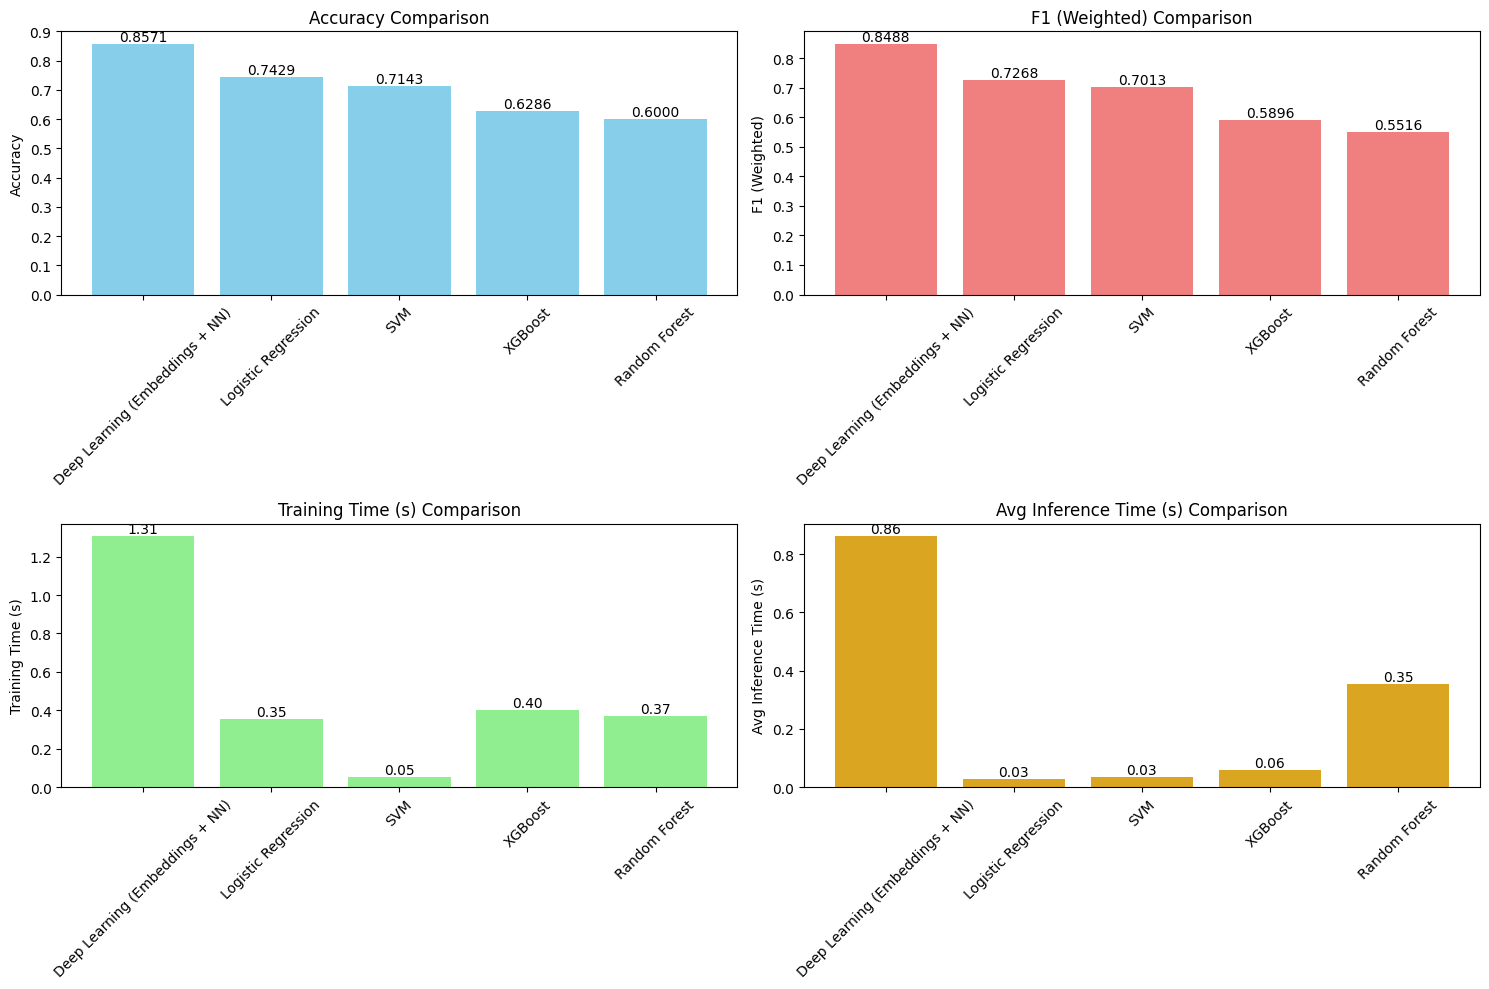


Per-class Performance Analysis:

Best Model (Deep Learning (Embeddings + NN)) - Per-class Results:
                                    Class  Precision  Recall  F1-Score  Support
                               Brake Drum     0.0000  0.0000    0.0000        0
                                   Brakes     1.0000  1.0000    1.0000        3
                                 Camshaft     1.0000  1.0000    1.0000        2
                         Camshaft Bearing     0.0000  0.0000    0.0000        0
               Camshaft Bearing Clearance     0.0000  0.0000    0.0000        0
                         Camshaft Housing     0.0000  0.0000    0.0000        0
                            Camshaft Seal     0.0000  0.0000    0.0000        0
                     Camshaft Timing Gear     0.0000  0.0000    0.0000        0
                       Combustion Chamber     0.0000  0.0000    0.0000        0
                         Cylinder Balance     0.0000  0.0000    0.0000        0
                    

In [43]:
# Create a comparison data frame
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision (Weighted)': metrics['precision_weighted'],
        'Recall (Weighted)': metrics['recall_weighted'],
        'F1 (Weighted)': metrics['f1_weighted'],
        'F1 (Micro)': metrics['f1_micro'],
        'Training Time (s)': metrics['train_time'],
        'Avg Inference Time (s)': metrics['inference_time'],
        'Per Sample Time (s)': metrics['per_sample_time'],
        'Samples/sec': metrics['samples_per_second']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1 (Weighted)', ascending=False)

print("Model Comparison:")
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Plot comparison metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['Accuracy', 'F1 (Weighted)', 'Training Time (s)', 'Avg Inference Time (s)']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'goldenrod']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[idx])
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}' if metric in ['Accuracy', 'F1 (Weighted)'] else f'{height:.2f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Per-class performance analysis
class_names = label_encoder.classes_
print("\nPer-class Performance Analysis:")
best_model = comparison_df.iloc[0]['Model']
best_metrics = results[best_model]

per_class_df = pd.DataFrame({
    'Class': class_names,
    'Precision': best_metrics['precision_per_class'],
    'Recall': best_metrics['recall_per_class'],
    'F1-Score': best_metrics['f1_per_class'],
    'Support': best_metrics['support_per_class']
})

print(f"\nBest Model ({best_model}) - Per-class Results:")
print(per_class_df.to_string(index=False, float_format='%.4f'))

print("\nSUMMARY:")
print(f"Best performing model: {comparison_df.iloc[0]['Model']}")
print(f"Best F1 (Weighted): {comparison_df.iloc[0]['F1 (Weighted)']:.4f}")
print(f"Best Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"Fastest training: {comparison_df.loc[comparison_df['Training Time (s)'].idxmin(), 'Model']}")
print(f"Fastest inference: {comparison_df.loc[comparison_df['Avg Inference Time (s)'].idxmin(), 'Model']}")

## Summary for training

**Disclaimer**: The dataset has few entries and the randomly chosen split might not be optimal, the following decisions were made using only the available training details and data.

So, after training, we can see that the Deep Learning approach has the highest accuracy and precision (with a difference of 10% in comparison with the following model). However, its disadvantage is the inference time, where it can only handle about 40 samples per second. In comparison, the LR or SVM can handle about 1000 samples per second, which is 25x faster. The training time is also much slower (1.3s vs 0.05 - 0.35s).

We should now make a decision on what model to choose next. Given these details and the requirements (10 mil. queries per day and $0.0005 per incorrect classification), I would go with the deep learning approach. If we consider the 10\% difference in accuracy, that would approximately mean 500\$ are lost per day due to choosing a model with a lower accuracy (the SVM or LR in this case), money which could go on renting more CPU or GPU resources in order to make up for the 25x slower inference time (as an approximation, a [GPU EC2 instance from AWS](https://instances.vantage.sh/aws/ec2/g5.xlarge?currency=USD) would cost ~26\$ a day and would significantly increase the inference speed of the model).

Moreover, we can always try to further optimize the transformer model using HuggingFace optimum for CPU (using openvino) or GPU (using onnx) or we may try different embeddings models in the future which furtherly increase the accuracy (so decrease the cost) or try batching. By choosing a simpler model instead, we would not have similar options.

# Training for the real world scenario

Now that we chose the embedding model, it is time to train it on the whole dataset, figure a threshold for the unknown cases (ie: if the maximum softmax prediction for an entry is lower than this threshold, we claim that the confidence is low and mark it as "unknown"), save the weights and define a simple interface for the prediction model.

In [85]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import time
import pickle
import json
from abc import ABC, abstractmethod
from typing import Union, List, Tuple

In [77]:
# Load the datasets again
dataset = pd.read_csv('dataset.csv')
tax = pd.read_csv('tax.csv')

clean_dataset = dataset[dataset['name'] != 'unknown'].copy().reset_index(drop=True)
name_to_section = dict(zip(tax['name'], tax['section']))

# Create labels by combining section and name
clean_dataset['combined_label'] = clean_dataset['section'] + '|' + clean_dataset['name']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(clean_dataset['combined_label'])

In [78]:
# Create a dataset loader for the training
class RepairDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {'text': self.texts[idx]}
        if self.labels is not None:
            item['label'] = torch.LongTensor([self.labels[idx]])
        return item

def collate_fn(batch):
    texts = [item['text'] for item in batch]
    result = {'texts': texts}

    if 'label' in batch[0]:
        labels = torch.cat([item['label'] for item in batch])
        result['labels'] = labels

    return result

In [80]:
class RepairClassifier(ABC):
    """Abstract base class for repair classification"""

    @abstractmethod
    def predict(self, texts: str | List[str]) -> Tuple[str, str] | List[Tuple[str, str]]:
        """
        Predict section and name for input text(s).

        Args:
            texts: Single text string or list of text strings

        Returns:
            Single (section, name) tuple or list of (section, name) tuples
        """
        pass

In [86]:
class EmbeddingRepairClassifier(nn.Module, RepairClassifier):
    """End-to-end repair classifier with single classification head"""

    def __init__(self, embedding_model_name='all-MiniLM-L6-v2',
                 num_classes=None, hidden_dim=128, dropout=0.3,
                 threshold=0.7, label_encoder=None):
        super(EmbeddingRepairClassifier, self).__init__()

        # Load pre-trained sentence transformer
        self.sentence_transformer = SentenceTransformer(embedding_model_name)

        # Freeze embeddings
        for param in self.sentence_transformer.parameters():
            param.requires_grad = False

        # Get embedding dimension
        self.embedding_dim = self.sentence_transformer.get_sentence_embedding_dimension()

        # Single classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        self.threshold = threshold
        self.label_encoder = label_encoder

    def forward(self, texts):
        # Generate embeddings
        if isinstance(texts, list):
            embeddings = self.sentence_transformer.encode(texts, convert_to_tensor=True,
                                                        device=next(self.parameters()).device)
            # Clone to make it a normal tensor for autograd, otherwise it causes errors
            embeddings = embeddings.clone().detach().requires_grad_(True)
        else:
            embeddings = texts

        # Classification
        logits = self.classifier(embeddings)
        return logits

    def predict(self, texts: str | List[str]) -> Tuple[str, str] | List[Tuple[str, str]]:
        """Predict section and name for input text(s)"""
        single_input = isinstance(texts, str)
        if single_input:
            texts = [texts]

        self.eval()
        with torch.no_grad():
            logits = self.forward(texts)
            probs = F.softmax(logits, dim=1)
            max_probs, predictions = torch.max(probs, dim=1)

            results = []
            for i in range(len(texts)):
                if max_probs[i].item() < self.threshold:
                    results.append(("unknown", "unknown"))
                else:
                    combined_label = self.label_encoder.inverse_transform([predictions[i].cpu().numpy()])[0]
                    section, name = combined_label.split('|')
                    results.append((section, name))

        return results[0] if single_input else results

In [87]:
def train_model(model, train_loader, epochs=40, lr=0.001, weight_decay=1e-4):
    """Train the model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    print(f"Training on device: {device}")
    print(f"Training for {epochs} epochs...")

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total_samples = 0

        for batch_idx, batch in enumerate(train_loader):
            texts = batch['texts']
            labels = batch['labels'].squeeze().to(device)

            optimizer.zero_grad()

            logits = model(texts)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total_samples

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}: Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

In [89]:
# Create dataset and dataloader
train_dataset = RepairDataset(clean_dataset['title'].values, y_encoded)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Initialize and train model
model = EmbeddingRepairClassifier(
    num_classes=len(label_encoder.classes_),
    threshold=0.7,
    label_encoder=label_encoder
)

print(f"Model initialized with {len(label_encoder.classes_)} classes")

# Train the model
train_model(model, train_loader, epochs=40)

# Example usage
print("\nExample predictions:")
examples = [
    "Replacing brake pads on front wheel",
    "Installing new headlight bulb",
    "Some completely unknown repair task"
]

for text in examples:
    section, name = model.predict(text)
    print(f"'{text}' - Section: {section}, Name: {name}")

# Save everything together
print("\nSaving model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'model_config': {
        'embedding_model_name': 'all-MiniLM-L6-v2',
        'num_classes': len(label_encoder.classes_),
        'hidden_dim': 128,
        'dropout': 0.3,
        'threshold': 0.5
    }
}, 'repair_classifier.pth')

print("Model saved to 'repair_classifier.pth'")

Model initialized with 12 classes
Training on device: cpu
Training for 40 epochs...
Epoch 0/40: Loss: 2.4371, Accuracy: 0.2567
Epoch 10/40: Loss: 0.8329, Accuracy: 0.7433
Epoch 20/40: Loss: 0.3997, Accuracy: 0.8663
Epoch 30/40: Loss: 0.2056, Accuracy: 0.9251
Epoch 39/40: Loss: 0.1637, Accuracy: 0.9519

Example predictions:
'Replacing brake pads on front wheel' - Section: Brakes, Name: Brakes
'Installing new headlight bulb' - Section: unknown, Name: unknown
'Some completely unknown repair task' - Section: unknown, Name: unknown

Saving model...
Model saved to 'repair_classifier.pth'


In [90]:
def evaluate_threshold(model, texts, true_labels, thresholds=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95]):
    """Evaluate model with different thresholds"""
    print(f"\nEvaluating thresholds on {len(texts)} samples:")

    for threshold in thresholds:
        model.threshold = threshold
        predictions = model.predict(texts)

        # Count valid predictions (not unknown)
        valid_predictions = [p for p in predictions if p != ("unknown", "unknown")]
        valid_count = len(valid_predictions)

        if valid_count > 0:
            # Calculate accuracy on valid predictions
            true_valid = []
            pred_valid = []
            for i, pred in enumerate(predictions):
                if pred != ("unknown", "unknown"):
                    true_combined = true_labels[i]
                    pred_combined = f"{pred[0]}|{pred[1]}"
                    true_valid.append(true_combined)
                    pred_valid.append(pred_combined)

            if true_valid:
                accuracy = sum(1 for t, p in zip(true_valid, pred_valid) if t == p) / len(true_valid)
            else:
                accuracy = 0.0
        else:
            accuracy = 0.0

        print(f"Threshold {threshold:.2f}: {valid_count}/{len(texts)} valid predictions, "
              f"Accuracy: {accuracy:.3f}")

In [91]:
# Evaluate on training data with different thresholds
evaluate_threshold(model, clean_dataset['title'].tolist(), clean_dataset['combined_label'].tolist())

# Test on unknown entries if they exist
unknown_data = dataset[dataset['name'] == 'unknown']
if len(unknown_data) > 0:
    print(f"\nTesting on {len(unknown_data)} unknown entries:")
    unknown_predictions = model.predict(unknown_data['title'].tolist())

    for threshold in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
        model.threshold = threshold
        unknown_pred = model.predict(unknown_data['title'].tolist())
        unknown_count = sum(1 for p in unknown_pred if p == ("unknown", "unknown"))
        print(f"Threshold {threshold:.2f}: {unknown_count}/{len(unknown_data)} "
              f"({unknown_count/len(unknown_data)*100:.1f}%) detected as unknown")


Evaluating thresholds on 187 samples:
Threshold 0.50: 180/187 valid predictions, Accuracy: 0.989
Threshold 0.60: 178/187 valid predictions, Accuracy: 0.994
Threshold 0.70: 175/187 valid predictions, Accuracy: 1.000
Threshold 0.80: 165/187 valid predictions, Accuracy: 1.000
Threshold 0.90: 155/187 valid predictions, Accuracy: 1.000
Threshold 0.95: 146/187 valid predictions, Accuracy: 1.000

Testing on 15 unknown entries:
Threshold 0.50: 7/15 (46.7%) detected as unknown
Threshold 0.60: 7/15 (46.7%) detected as unknown
Threshold 0.70: 11/15 (73.3%) detected as unknown
Threshold 0.80: 11/15 (73.3%) detected as unknown
Threshold 0.90: 13/15 (86.7%) detected as unknown
Threshold 0.95: 13/15 (86.7%) detected as unknown


Based on the evaluations for different threshold values, a value of 0.5 should be enough. It maintains 96% of the true predictions, while marking 46% of the unknown entries as unknown.

In [92]:
class DeployedRepairClassifier(RepairClassifier):
    """Simple deployment wrapper - loads from single file"""

    def __init__(self, model_path: str):
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

        config = checkpoint['model_config']
        self.label_encoder = checkpoint['label_encoder']

        # Recreate model
        self.model = EmbeddingRepairClassifier(
            embedding_model_name=config['embedding_model_name'],
            num_classes=config['num_classes'],
            hidden_dim=config['hidden_dim'],
            dropout=config['dropout'],
            threshold=config['threshold'],
            label_encoder=self.label_encoder
        )

        # Load weights
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        print(f"Model loaded with {config['num_classes']} classes, threshold: {config['threshold']}")

    def set_threshold(self, threshold: float):
        """Update the confidence threshold"""
        self.model.threshold = threshold

    def predict(self, texts: str | List[str]) -> Tuple[str, str] | List[Tuple[str, str]]:
        """Predict section and name for input text(s)"""
        return self.model.predict(texts)

In [93]:
deployed_model = DeployedRepairClassifier('repair_classifier.pth')
result = deployed_model.predict("Replace brake caliper")
print(f"Section: {result[0]}, Name: {result[1]}")

Model loaded with 12 classes, threshold: 0.5
Section: Brakes, Name: Disc Brake Caliper


In [110]:
# Let's also check the unknown cases
SIMILARITY_THRESHOLD = 0.55 # for the distance check
MODEL_THRESHOLD = 0.5 # for the model check

similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

all_titles = dataset['title'].tolist()
embeddings = similarity_model.encode(all_titles)

# Store the unknown and known cases
unknown_indices = dataset[dataset['section'] == 'unknown'].index.tolist()
known_indices = dataset[dataset['section'] != 'unknown'].index.tolist()

passing_indices = []

for unknown_idx in unknown_indices:
    unknown_emb = embeddings[unknown_idx].reshape(1, -1)
    known_embs = embeddings[known_indices]

    sims = cosine_similarity(unknown_emb, known_embs)[0]
    max_sim_idx = np.argmax(sims)
    max_similarity = sims[max_sim_idx]
    most_similar_idx = known_indices[max_sim_idx]

    if max_similarity >= SIMILARITY_THRESHOLD:
        passing_indices.append(unknown_idx)

model.threshold = MODEL_THRESHOLD

for index in passing_indices:
    result = deployed_model.predict(dataset.loc[index, 'title'])
    if result[0] != 'unknown':
        print(f"Title: {dataset.loc[index, 'title']}, classification: {result}")

# That is leaving us with only 3 false positives

Title: Removing and installing/replacing trim on C-pillar at bottom left or right, classification: ('Lighting', 'Interior Bulb')
Title: Replacing rear left side panel, classification: ('Lighting', 'Exterior Bulb')
Title: Replace tail panel outer section and inner section, classification: ('Lighting', 'Exterior Bulb')


# Summary

We analysed the provided data, trained a model that has an 85% accuracy on the data and then saved its weights, so that it can be used for serving. We also defined a simple interface for the serving model, that can handle both single and batching inference. Also, we investigated ways to filter out 80% of the unknown data, using simple distance and softmax tresholds.